# Denoising MNIST Digit Dataset
## AAI 551 Python Final Project
#### I will be using a Convolutional Autoencoder to denoise images from the MNIST dataset. I'll start by creating a function to generate and compile models. I'll see how a random model does, and then use a Random Search Cross Validation function to find more optimal hyperparameters for my model.

#### I used the following resources for this project:
##### [Autoencoders Using Keras](https://blog.keras.io/building-autoencoders-in-keras.html)
##### [Getting Started With Keras Tuner](https://keras.io/guides/keras_tuner/getting_started/)
##### [Introduction to the Keras Tuner](https://www.tensorflow.org/tutorials/keras/keras_tuner)
##### [Keras Hyperparameters Class API Reference](https://keras.io/api/keras_tuner/hyperparameters/#hyperparameters-class)

#### The basic structure of an Autoencoder model is shown below:
![ae_diagram](images/ae_diagram.png)

In [1]:
!pip install keras-tuner -q # Need to install when running in Google Colab

     |████████████████████████████████| 133 kB 9.5 MB/s eta 0:00:01


## Load MNIST Digits Dataset

11501568/11490434 [==============================] - 0s 0us/step
Train Set Shape: (60000, 28, 28)
Test Set Shape: (10000, 28, 28)


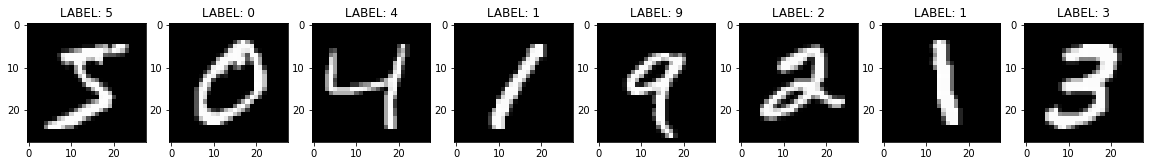

In [2]:
# Load modules needed for loading and preparing data
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

# Load mnist digits dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print("Train Set Shape:", x_train.shape)
print("Test Set Shape:", x_test.shape)

# Function for plotting digit images and their associated labels
def plotData(x,label):
    imgs = x[:8]
    fig = plt.figure(figsize=[20,5])

    for num, pic in enumerate(imgs):
        plot = fig.add_subplot(1,8,num+1)
        plot.title.set_text("LABEL: " + label[num].astype(str))
        pic = pic.reshape(28,28)
        plot.imshow(pic, cmap='gray')

    plt.show()
    return

plotData(x_train, y_train)

## Preprocess & Add Noise to the Dataset

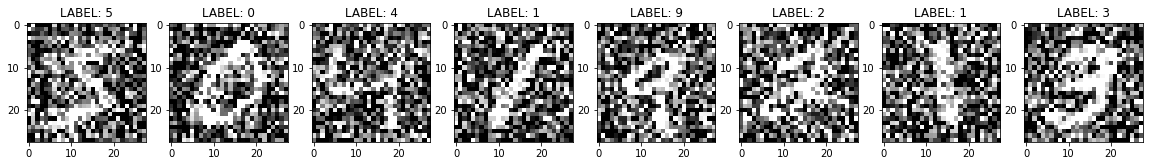

In [3]:
# Ensure data is in float32 in order to be properly trained
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# Normalize pixel values to be between 0 and 1
x_train = x_train/255
x_test = x_test/255

# Add gaussian noise to data for input to AE
nf = 0.3 # Noise Factor
x_train_noisy = x_train + nf + np.random.normal(loc=0.0, scale=0.5, size = x_train.shape)
x_test_noisy = x_test + nf + np.random.normal(loc=0.0, scale=0.5, size = x_test.shape)

# Ensure pixel values are held between 0 and 1
x_train_noisy = np.clip(x_train_noisy,0.,1.)
x_test_noisy = np.clip(x_test_noisy,0.,1.)

# Plot noisy dataset (input to AE)
plotData(x_train_noisy, y_train)

# Create Conv AE Models with appropriate activation functions

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


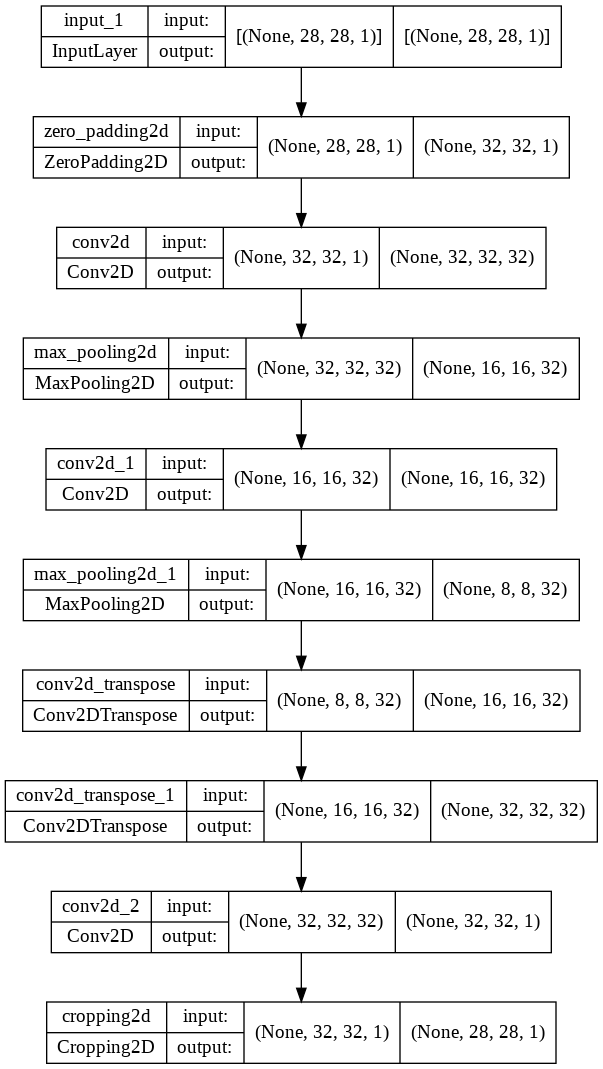

In [4]:
# Import Modules for AE model creation
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, LeakyReLU, ZeroPadding2D,Cropping2D
from keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam, Adagrad, Adadelta, RMSprop
from tensorflow.keras.utils import plot_model

# Preset number of filters at output of each layer
filt = [[64,32,16], [64,32],[32,32], [32,64], [16,32,64]]

# Function for generating AE model with specified hyperparameterts
def makeModel(opt='adam', act = 'relu', lr = 0.0001, filters = 2):
    # Input layer 
    input = Input(shape=(28,28,1))
    # Zero pad to 32 to ensure different model depths will work
    x = ZeroPadding2D(padding=2)(input)

    # Encoder filters will follow order from filt
    encFilters = filt[filters]
    # Decoder filters will follow reversed order from filt, skipping the last value
    decFilters = [encFilters[i] for i in reversed(range(len(encFilters)))]

    if act == 'leakyrelu': # LeakyRelu can't be accessed through a parameter

    # Create encoder stage
    for filter in encFilters:
        x = Conv2D(filter, (3,3), padding='same')(x)
        x = LeakyReLU()(x)
        x = MaxPooling2D((2,2), padding='same')(x)

    # Create decoder stage
    for filter in decFilters:
        x = Conv2DTranspose(filter, (3,3), strides=2, padding='same')(x)
        x = LeakyReLU()(x)

    else: # All activations besides LeakyRelu can be access through a parameter

    # Create encoder stage
    for filter in encFilters:
        x = Conv2D(filter, (3,3), activation=act, padding='same')(x)
        x = MaxPooling2D((2,2), padding='same')(x)

    # create Decoder stage
    for filter in decFilters:
        x = Conv2DTranspose(filter, (3,3), strides=2, padding='same')(x)

    # Final Conv layer used to get appropriate output dimensions
    x = Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')(x)
    # Crop output from (32,32) back to (28,28)
    output = Cropping2D(cropping=2)(x)

    # Set Optimizer and learning rate
    if opt == 'adam':
        opt = Adam(learning_rate=lr)
    elif opt == 'sgd':
        opt = SGD(lr=lr)
    elif opt == 'adagrad':
        opt = Adagrad(learning_rate=lr)
    elif opt == 'adadelta':
        opt = Adadelta(learning_rate=lr)
    elif opt == 'rmsprop':
        opt = RMSprop(learning_rate=lr)

    # Create model
    model = Model(input,output)
    # Compile model
    model.compile(optimizer=opt, loss='binary_crossentropy',metrics=['acc'])
    return model


model = makeModel(opt='sgd', act = 'sigmoid', lr = 0.01, filters = 2)
plot_model(model,show_shapes=True)

## Train Initial Model

In [5]:
# Split training into train/validation set
num_val = 1000
num_train = x_train.shape[0] - num_val

# Train Initial Model
hist = model.fit(x_train_noisy[:num_train],
                 x_train[:num_train],
                 validation_data = (x_train_noisy[num_train:], 
                                    x_train[num_train:]),
                 batch_size=512,
                 epochs=25)

Epoch 1/25
116/116 [==============================] - 17s 35ms/step - loss: 0.4900 - acc: 0.7885 - val_loss: 0.4130 - val_acc: 0.7978
Epoch 2/25
116/116 [==============================] - 3s 29ms/step - loss: 0.3917 - acc: 0.8090 - val_loss: 0.4079 - val_acc: 0.7978
Epoch 3/25
116/116 [==============================] - 3s 29ms/step - loss: 0.3892 - acc: 0.8090 - val_loss: 0.4071 - val_acc: 0.7978
Epoch 4/25
116/116 [==============================] - 3s 29ms/step - loss: 0.3884 - acc: 0.8090 - val_loss: 0.4064 - val_acc: 0.7978
Epoch 5/25
116/116 [==============================] - 3s 29ms/step - loss: 0.3877 - acc: 0.8090 - val_loss: 0.4059 - val_acc: 0.7978
Epoch 6/25
116/116 [==============================] - 3s 29ms/step - loss: 0.3872 - acc: 0.8090 - val_loss: 0.4054 - val_acc: 0.7978
Epoch 7/25
116/116 [==============================] - 3s 29ms/step - loss: 0.3868 - acc: 0.8090 - val_loss: 0.4050 - val_acc: 0.7978
Epoch 8/25
116/116 [==============================] - 3s 29ms/step -

In [6]:
# Mount GDrive to save initial model
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [7]:
# Save Initial Model
model.save("/content/gdrive/MyDrive/Colab Notebooks/AAI551/initial/model")

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/AAI551/initial/model/assets


## View Results of Initial Model


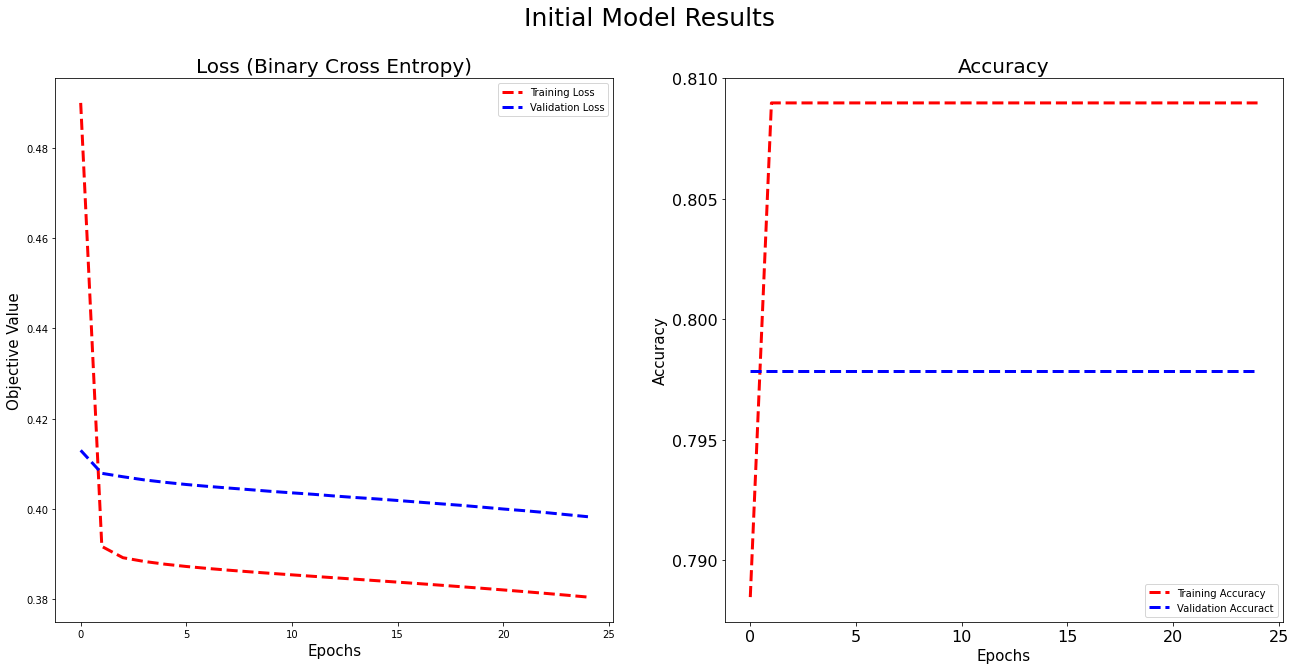

In [8]:
# Plot training/validation loss and accuracy
fig, axs = plt.subplots(1,2, figsize=(22, 10))
fig.suptitle("Initial Model Results", fontsize=25)

epoch_range = np.arange(25)

# Loss Subplot
axs[0].plot(epoch_range, hist.history['loss'], '--r', linewidth=3)
axs[0].plot(epoch_range, hist.history['val_loss'], '--b', linewidth=3)

axs[0].set_title("Loss (Binary Cross Entropy)", fontsize=20)
axs[0].set_xlabel('Epochs', fontsize=15)
axs[0].set_ylabel('Objective Value', fontsize=15)
axs[0].legend(['Training Loss', 'Validation Loss'])
plt.tick_params(axis='both', which='major', labelsize=16)

# Accuracy Subplot
axs[1].plot(epoch_range, hist.history['acc'], '--r', linewidth=3)
axs[1].plot(epoch_range, hist.history['val_acc'], '--b', linewidth=3)

axs[1].set_title("Accuracy", fontsize=20)
axs[1].set_xlabel('Epochs', fontsize=15)
axs[1].set_ylabel('Accuracy', fontsize=15)
axs[1].legend(['Training Accuracy', 'Validation Accuract'])
plt.tick_params(axis='both', which='major', labelsize=16)


plt.show()

Test Samples


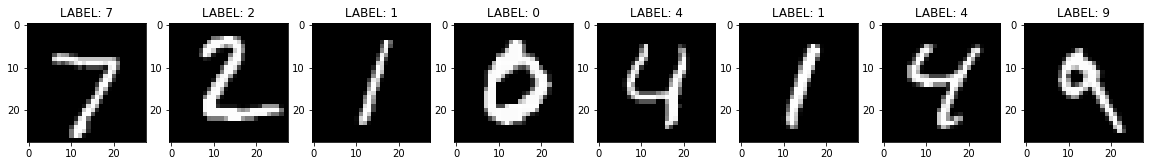

Noisy Test Sample Input


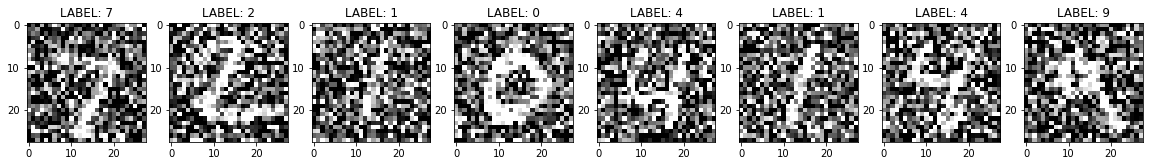

Initial Model Predictions


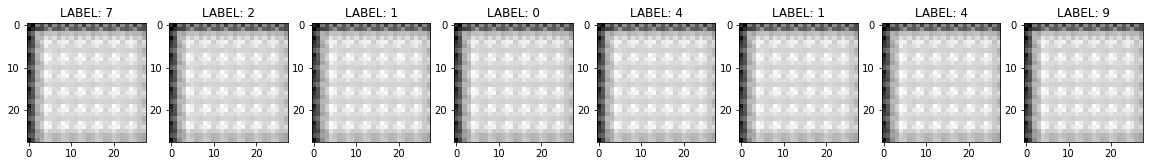

In [9]:
print("Test Samples")
plotData(x_test, y_test)
print("Noisy Test Sample Input")
plotData(x_test_noisy,y_test)

pred = model.predict(x_test_noisy)
print("Initial Model Predictions")
plotData(pred,y_test)

In [10]:
print("Test Set Loss and Accuracy of Initial Model\n")
results = model.evaluate(x_test_noisy,x_test, verbose=0)
print(f"Loss: {np.round(results[0],2)}\nAccuracy: {np.round(results[1],2)}")

Test Set Loss and Accuracy of Initial Model

Loss: 0.38
Accuracy: 0.81


## Perform Hyperparameter Tuning Using Keras Tuner to Improve Model

In [11]:
# load keras tuner module
import keras_tuner

# wrapper function for makeModel that can be passed into 
# keras tuner object to test models with different hyperparameters
def tuneModel(hp):
    opt  = hp.Choice("opt", ['adam', 'sgd', 'adagrad','adadelta', 'rmsprop'])
    act = hp.Choice("act", ['relu', 'leakyrelu', 'sigmoid', 'tanh'])
    lr = hp.Choice("lr", [0.001, 0.01, 0.1])
    filters = hp.Choice("filt", [0,1,2,3,4])
    # call existing model-building code with the hyperparameter values.
    model = makeModel(
        opt=opt, act = act, lr =lr, filters = filters
        )
    return model

In [12]:
# check that function works
tuneModel(keras_tuner.HyperParameters())

In [13]:
# Create tuner object to run random search to compare 
# different models and find best hyperparameters
tuner = keras_tuner.RandomSearch(
      tuneModel,
      objective='val_loss',
      max_trials=15
)

# Search for best hyper parameters
tuner.search(x_train_noisy[:num_train], x_train[:num_train],
             validation_data=(x_train_noisy[num_train:], x_train[num_train:]),
             batch_size=512,
             epochs=10)

# Store best model as output
best_model = tuner.get_best_models()[0]

Trial 15 Complete [00h 00m 42s]
val_loss: 0.1440712958574295

Best val_loss So Far: 0.1098671406507492
Total elapsed time: 00h 14m 04s
INFO:tensorflow:Oracle triggered exit


In [14]:
# Save Tuned Model
best_model.save("/content/gdrive/MyDrive/Colab Notebooks/AAI551/tuned/model")

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/AAI551/tuned/model/assets


## View Results of Tuned Model

In [15]:
# Get tuner trial summary
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
opt: adam
act: leakyrelu
lr: 0.01
filt: 0
Score: 0.1098671406507492
Trial summary
Hyperparameters:
opt: adam
act: relu
lr: 0.001
filt: 3
Score: 0.11469565331935883
Trial summary
Hyperparameters:
opt: adam
act: relu
lr: 0.01
filt: 2
Score: 0.11568482220172882
Trial summary
Hyperparameters:
opt: adam
act: leakyrelu
lr: 0.001
filt: 0
Score: 0.1283586323261261
Trial summary
Hyperparameters:
opt: adam
act: sigmoid
lr: 0.001
filt: 3
Score: 0.13637372851371765
Trial summary
Hyperparameters:
opt: rmsprop
act: sigmoid
lr: 0.01
filt: 2
Score: 0.1405607908964157
Trial summary
Hyperparameters:
opt: sgd
act: relu
lr: 0.1
filt: 3
Score: 0.1440712958574295
Trial summary
Hyperparameters:
opt: adagrad
act: relu
lr: 0.01
filt: 3
Score: 0.18128639459609985
Trial summary
Hyperparameters:
opt: sgd
act: tanh
lr: 0.01
filt: 3
Score: 0.3915254473686218
Trial summary
Hyperparameters:
opt: adadelta
act: relu
lr: 

Test Samples


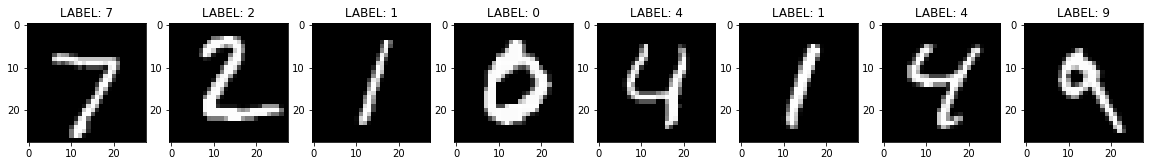

Noisy Test Sample Input


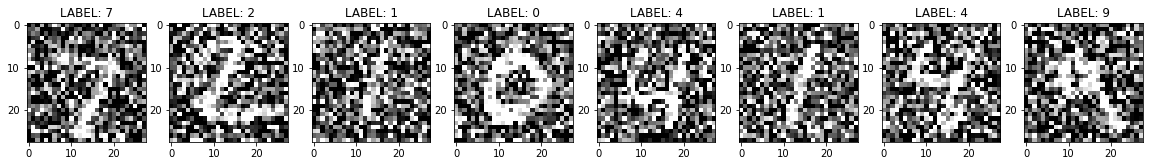

Initial Tuned Model Predictions


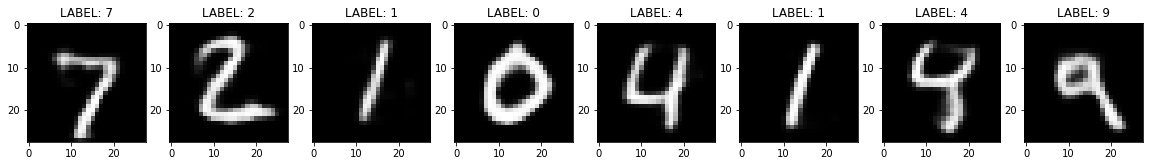

In [16]:
print("Test Samples")
plotData(x_test, y_test)
print("Noisy Test Sample Input")
plotData(x_test_noisy,y_test)

pred = best_model.predict(x_test_noisy)
print("Initial Tuned Model Predictions")
plotData(pred,y_test)

In [17]:
print("Test Set Loss and Accuracy of Initial Tuned Model\n")
results = best_model.evaluate(x_test_noisy,x_test, verbose=0)
print(f"Loss: {np.round(results[0],2)}\nAccuracy: {np.round(results[1],2)}")

Test Set Loss and Accuracy of Initial Tuned Model

Loss: 0.11
Accuracy: 0.81


## Use Entire Training Set To Train Model With Best Hyperparameters

In [18]:
# Get best hyperparameters from tuner search results
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Learning Rate: {best_hps.get('lr')}")
print(f"Best Optimizer: {best_hps.get('opt')}")
print(f"Best Activation Function: {best_hps.get('act')}")
print(f"Best Filter Depths: {filt[best_hps.get('filt')]}")

Best Learning Rate: 0.01
Best Optimizer: adam
Best Activation Function: leakyrelu
Best Filter Depths: [64, 32, 16]


In [19]:
# Train model with best hyperparameters using entire training set
final_model = tuner.hypermodel.build(best_hps)
hist = final_model.fit(x_train_noisy,
                    x_train,
                    batch_size = 512,
                    epochs=25)

Epoch 1/25
118/118 [==============================] - 8s 62ms/step - loss: 0.2843 - acc: 0.7936
Epoch 2/25
118/118 [==============================] - 7s 60ms/step - loss: 0.1643 - acc: 0.8015
Epoch 3/25
118/118 [==============================] - 7s 60ms/step - loss: 0.1410 - acc: 0.8063
Epoch 4/25
118/118 [==============================] - 7s 60ms/step - loss: 0.1293 - acc: 0.8085
Epoch 5/25
118/118 [==============================] - 7s 60ms/step - loss: 0.1239 - acc: 0.8095
Epoch 6/25
118/118 [==============================] - 7s 60ms/step - loss: 0.1198 - acc: 0.8102
Epoch 7/25
118/118 [==============================] - 7s 60ms/step - loss: 0.1170 - acc: 0.8107
Epoch 8/25
118/118 [==============================] - 7s 60ms/step - loss: 0.1154 - acc: 0.8109
Epoch 9/25
118/118 [==============================] - 7s 60ms/step - loss: 0.1132 - acc: 0.8113
Epoch 10/25
118/118 [==============================] - 7s 60ms/step - loss: 0.1123 - acc: 0.8114
Epoch 11/25
118/118 [==================

In [20]:
# Save Final Model
final_model.save("/content/gdrive/MyDrive/Colab Notebooks/AAI551/final/model")

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/AAI551/final/model/assets


## View Results of Final Model

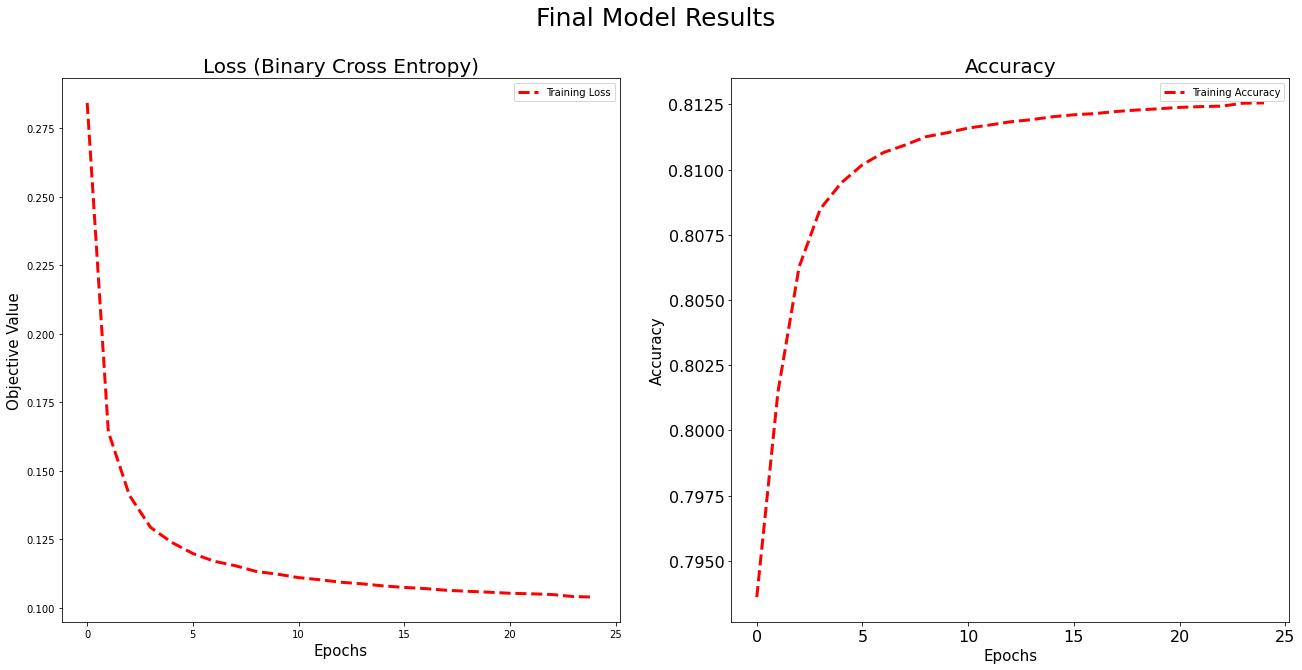

In [21]:
# Plot training/validation loss and accuracy
fig, axs = plt.subplots(1,2, figsize=(22, 10))
fig.suptitle("Final Model Results", fontsize=25)

epoch_range = np.arange(25)

# Loss Subplot
axs[0].plot(epoch_range, hist.history['loss'], '--r', linewidth=3)
axs[0].set_title("Loss (Binary Cross Entropy)", fontsize=20)
axs[0].set_xlabel('Epochs', fontsize=15)
axs[0].set_ylabel('Objective Value', fontsize=15)
axs[0].legend(['Training Loss'])
plt.tick_params(axis='both', which='major', labelsize=16)

# Accuracy Subplot
axs[1].plot(epoch_range, hist.history['acc'], '--r', linewidth=3)

axs[1].set_title("Accuracy", fontsize=20)
axs[1].set_xlabel('Epochs', fontsize=15)
axs[1].set_ylabel('Accuracy', fontsize=15)
axs[1].legend(['Training Accuracy'])
plt.tick_params(axis='both', which='major', labelsize=16)


plt.show()

Test Samples


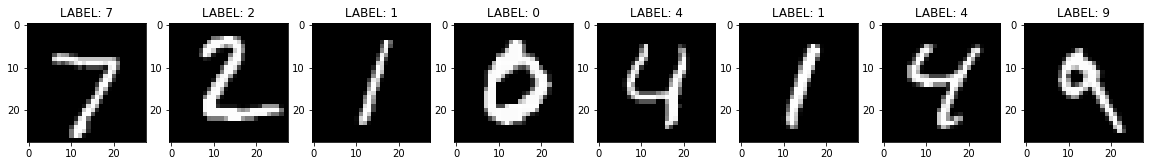

Noisy Test Sample Input


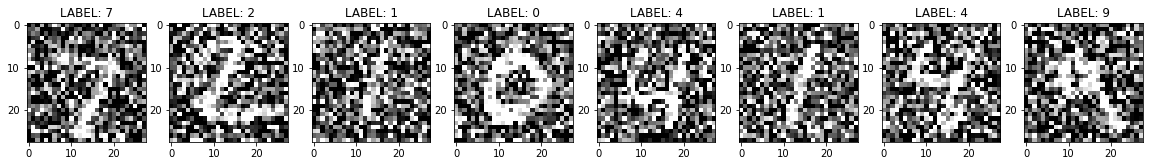

Final Model Predictions


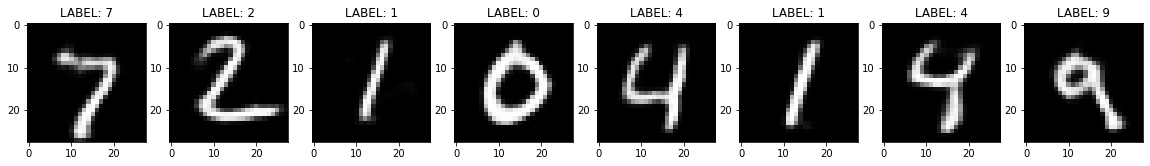

In [22]:
print("Test Samples")
plotData(x_test, y_test)
print("Noisy Test Sample Input")
plotData(x_test_noisy,y_test)

pred = final_model.predict(x_test_noisy)
print("Final Model Predictions")
plotData(pred,y_test)

In [23]:
print("Test Set Loss and Accuracy of Final Tuned Model\n")
results = final_model.evaluate(x_test_noisy,x_test, verbose=0)
print(f"Loss: {np.round(results[0],2)}\nAccuracy: {np.round(results[1],2)}")

Test Set Loss and Accuracy of Final Tuned Model

Loss: 0.1
Accuracy: 0.81
